In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [2]:
c_data = pd.read_csv('../data/data_cleaned.csv')

#### Drop Categorical feature

In [3]:
f_data = c_data.drop('Liability-Assets_Flag', axis=1)

Seperate the data

In [4]:
X = f_data.drop('Bankrupt?', axis=1)
y = f_data['Bankrupt?']

#### Dealing with Imbalanced Dataset

Apply SMOTE(Synthetic Minority Oversampling Technique) to generate synthetic samples from minority class to imbalanced target class problem.

In [5]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)
X_sm.shape, y_sm.shape

((13198, 93), (13198,))

In [6]:
y_sm.value_counts()

1    6599
0    6599
Name: Bankrupt?, dtype: int64

### Logistic Regression
- Logistic Regression(Base)
- Logistic Regression(Hyperparameter tuning)

#### Logistic Regression Base model

0.6103535353535353
              precision    recall  f1-score   support

           0       0.59      0.73      0.65      2005
           1       0.64      0.49      0.55      1955

    accuracy                           0.61      3960
   macro avg       0.62      0.61      0.60      3960
weighted avg       0.62      0.61      0.60      3960



<AxesSubplot:>

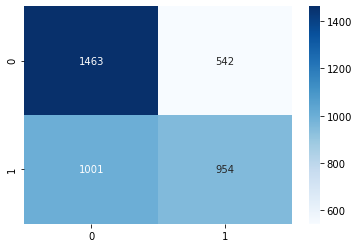

In [50]:
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.30, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues',fmt='d')

#### Hyperparameter Tuning

In [51]:
steps = [('scaler',StandardScaler()),
        ('classifier', LogisticRegression())]
pipeline = Pipeline(steps)

params = {'classifier__C':[1.0,10,100,0.1,0.01],
         'classifier__penalty':['l2'],
         'classifier__solver':['lbfgs', 'liblinear']}

cv = GridSearchCV(pipeline, param_grid=params, cv=3)
cv.fit(X_train, y_train)

y_pred = cv.predict(X_test)
print("Best: %f using %s" % (cv.best_score_, cv.best_params_))

Best: 0.906906 using {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sm)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_sm, test_size=0.30, random_state=42)

0.9027777777777778
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2005
           1       0.89      0.91      0.90      1955

    accuracy                           0.90      3960
   macro avg       0.90      0.90      0.90      3960
weighted avg       0.90      0.90      0.90      3960



<AxesSubplot:>

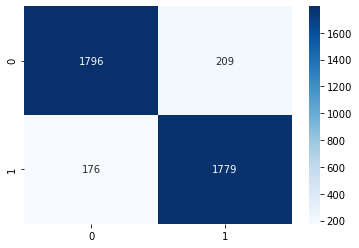

In [24]:
logreg_tuned=LogisticRegression(penalty='l2',C=1.0,solver='liblinear') 
logreg_tuned.fit(X_train, y_train)
y_pred = logreg_tuned.predict(X_test)

print(accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues',fmt='d')

#### Comparing ROC Curve between the models

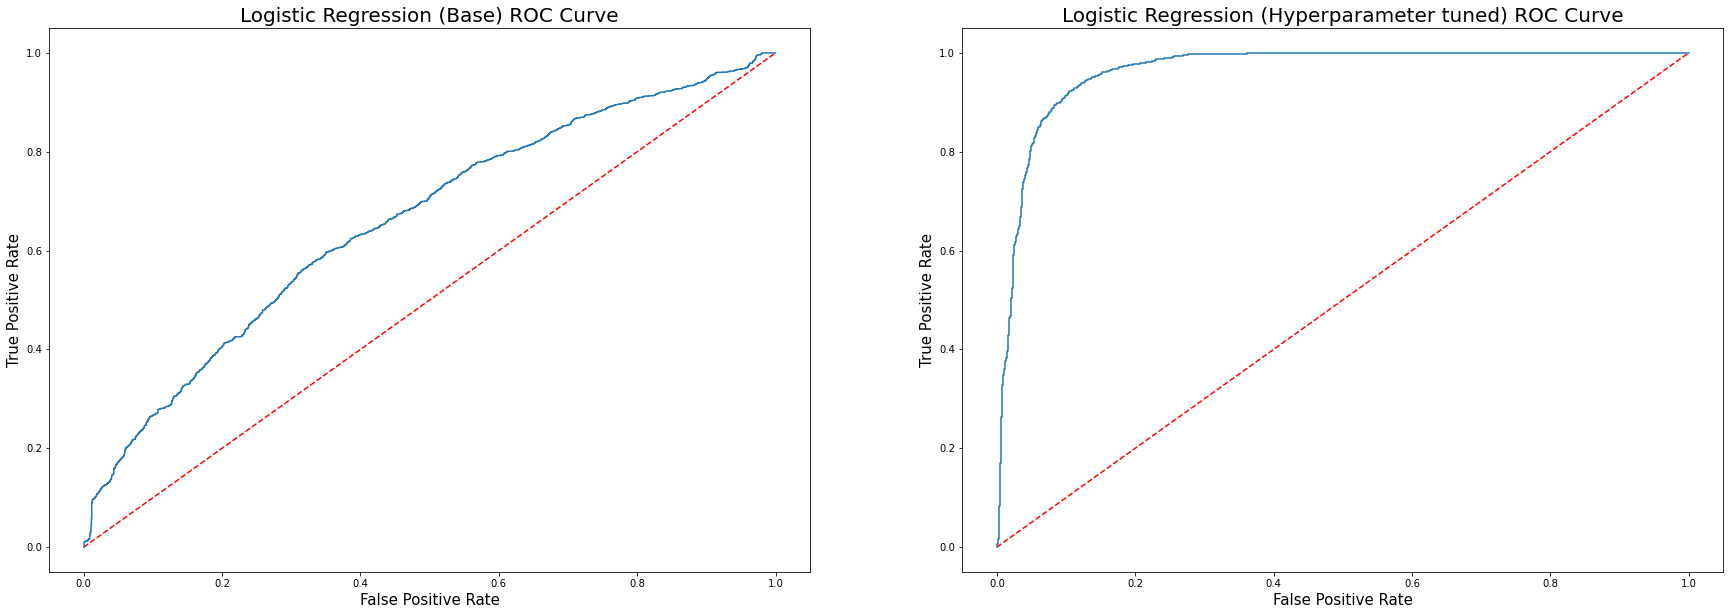

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
ax1.plot([0,1],[0,1], 'r--')
ax1.plot(fpr,tpr,label='Logistic Regression')
ax1.set_xlabel('False Positive Rate',fontsize=15)
ax1.set_ylabel('True Positive Rate',fontsize=15)
ax1.set_title('Logistic Regression (Base) ROC Curve',fontsize=20)

y_pred_logtune = logreg_tuned.predict_proba(X_test)[:,1]
hp_fpr, hp_tpr, hp_thresholds =roc_curve(y_test, y_pred_logtune)
ax2.plot([0,1],[0,1], 'r--')
ax2.plot(hp_fpr,hp_tpr,label='Logistic Regression')
ax2.set_xlabel('False Positive Rate',fontsize=15)
ax2.set_ylabel('True Positive Rate',fontsize=15)
ax2.set_title('Logistic Regression (Hyperparameter tuned) ROC Curve', fontsize=20)
plt.show();

### Random Forrest Classifier

#### RandomizedSearchCV

In [8]:
rf = RandomForestClassifier()
estimators = [int(x) for x in np.linspace(start=200, stop=1000, num=10)]
depth = [int(x) for x in np.linspace(10, 100, num=10)]

param = {
    'n_estimators': estimators,
    'max_depth': depth,
    'criterion': ['gini','entropy'],
    'max_features':['auto','sqrt']    
}
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param, cv=3, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=42)

In [9]:
rf_random.best_score_

0.9702315574433146

In [10]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=50, max_features='sqrt', n_estimators=555)

In [10]:
rf_random.best_params_

{'n_estimators': 555,
 'max_features': 'auto',
 'max_depth': 50,
 'criterion': 'gini'}

In [24]:
df = pd.DataFrame(rf_random.cv_results_)
df = df.set_index('rank_test_score')
df.sort_index()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,
1,30.402999,1.179221,0.445667,0.024581,555,auto,50,gini,"{'n_estimators': 555, 'max_features': 'auto', ...",0.969805,0.963625,0.975966,0.969799,0.005038
2,39.289002,0.927838,0.510998,0.026984,733,auto,70,gini,"{'n_estimators': 733, 'max_features': 'auto', ...",0.969481,0.963300,0.976291,0.969690,0.005306
3,25.941666,0.242578,0.381000,0.003741,466,sqrt,20,gini,"{'n_estimators': 466, 'max_features': 'sqrt', ...",0.969805,0.962975,0.975966,0.969582,0.005306
4,30.979999,0.720347,0.429000,0.006976,555,sqrt,50,gini,"{'n_estimators': 555, 'max_features': 'sqrt', ...",0.970130,0.963949,0.974342,0.969474,0.004268
5,25.919333,0.906960,0.359000,0.009899,466,sqrt,50,gini,"{'n_estimators': 466, 'max_features': 'sqrt', ...",0.968182,0.963300,0.975641,0.969041,0.005075
6,67.470000,0.731916,0.735333,0.026233,1000,auto,70,entropy,"{'n_estimators': 1000, 'max_features': 'auto',...",0.969156,0.963625,0.973693,0.968824,0.004117
7,48.887999,1.424799,0.504000,0.016872,733,auto,40,entropy,"{'n_estimators': 733, 'max_features': 'auto', ...",0.968831,0.962325,0.974667,0.968608,0.005041
8,13.728998,0.474498,0.150001,0.008832,200,auto,50,entropy,"{'n_estimators': 200, 'max_features': 'auto', ...",0.968831,0.963625,0.973368,0.968608,0.003981
9,61.762665,0.272079,0.675667,0.004920,1000,auto,10,entropy,"{'n_estimators': 1000, 'max_features': 'auto',...",0.961688,0.957454,0.968171,0.962438,0.004407


In [12]:
rfc1 = RandomForestClassifier(n_estimators=555, max_features='auto', max_depth=50, criterion='gini', random_state=42)
rfc1.fit(X_train, y_train)
pred = rfc1.predict(X_test)
print(accuracy_score(pred, y_test))

0.9775252525252526


#### GridSearchCV

In [16]:
param = {
    'n_estimators': [400,500,600,700],
    'max_depth': [20,50,70],
    'criterion': ['gini'],
    'max_features':['auto']    
}
rfg = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(estimator=rfg, param_grid=param, cv=3, n_jobs=-1)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [20, 50, 70],
                         'max_features': ['auto'],
                         'n_estimators': [400, 500, 600, 700]})

In [17]:
rf_grid.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'n_estimators': 400}

In [19]:
df1 = pd.DataFrame(rf_grid.cv_results_)
df1 = df1.set_index('rank_test_score')
df1.sort_index()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,
1,21.330055,0.414284,0.313666,0.002054,gini,20,auto,400,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.972078,0.963949,0.974342,0.970123,0.004462
2,32.703666,0.599957,0.464667,0.011324,gini,50,auto,600,"{'criterion': 'gini', 'max_depth': 50, 'max_fe...",0.971104,0.963949,0.974667,0.969907,0.004457
2,38.197332,0.657603,0.587000,0.044952,gini,50,auto,700,"{'criterion': 'gini', 'max_depth': 50, 'max_fe...",0.971104,0.963949,0.974667,0.969907,0.004457
2,33.385060,1.129537,0.450667,0.016857,gini,70,auto,600,"{'criterion': 'gini', 'max_depth': 70, 'max_fe...",0.971104,0.963949,0.974667,0.969907,0.004457
2,34.208671,0.288821,0.449666,0.006803,gini,70,auto,700,"{'criterion': 'gini', 'max_depth': 70, 'max_fe...",0.971104,0.963949,0.974667,0.969907,0.004457
6,22.232962,0.346310,0.317667,0.013720,gini,50,auto,400,"{'criterion': 'gini', 'max_depth': 50, 'max_fe...",0.971429,0.963625,0.974342,0.969798,0.004525
6,21.921530,0.482642,0.332333,0.010874,gini,70,auto,400,"{'criterion': 'gini', 'max_depth': 70, 'max_fe...",0.971429,0.963625,0.974342,0.969798,0.004525
8,27.064720,0.384911,0.393667,0.010841,gini,50,auto,500,"{'criterion': 'gini', 'max_depth': 50, 'max_fe...",0.970455,0.963949,0.974667,0.969690,0.004409
8,27.677256,0.736267,0.389000,0.004243,gini,70,auto,500,"{'criterion': 'gini', 'max_depth': 70, 'max_fe...",0.970455,0.963949,0.974667,0.969690,0.004409


In [20]:
rfc2 = RandomForestClassifier(n_estimators=400, max_features='auto', max_depth=20, criterion='gini', random_state=42)
rfc2.fit(X_train, y_train)
pred_g = rfc2.predict(X_test)

0.9777777777777777


0.9777777777777777
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2005
           1       0.96      0.99      0.98      1955

    accuracy                           0.98      3960
   macro avg       0.98      0.98      0.98      3960
weighted avg       0.98      0.98      0.98      3960



<AxesSubplot:>

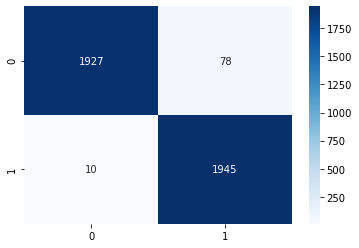

In [22]:
print(accuracy_score(pred_g, y_test))
print(classification_report(y_test, pred_g))
sns.heatmap(confusion_matrix(y_test, pred_g), annot=True, cmap='Blues',fmt='d')

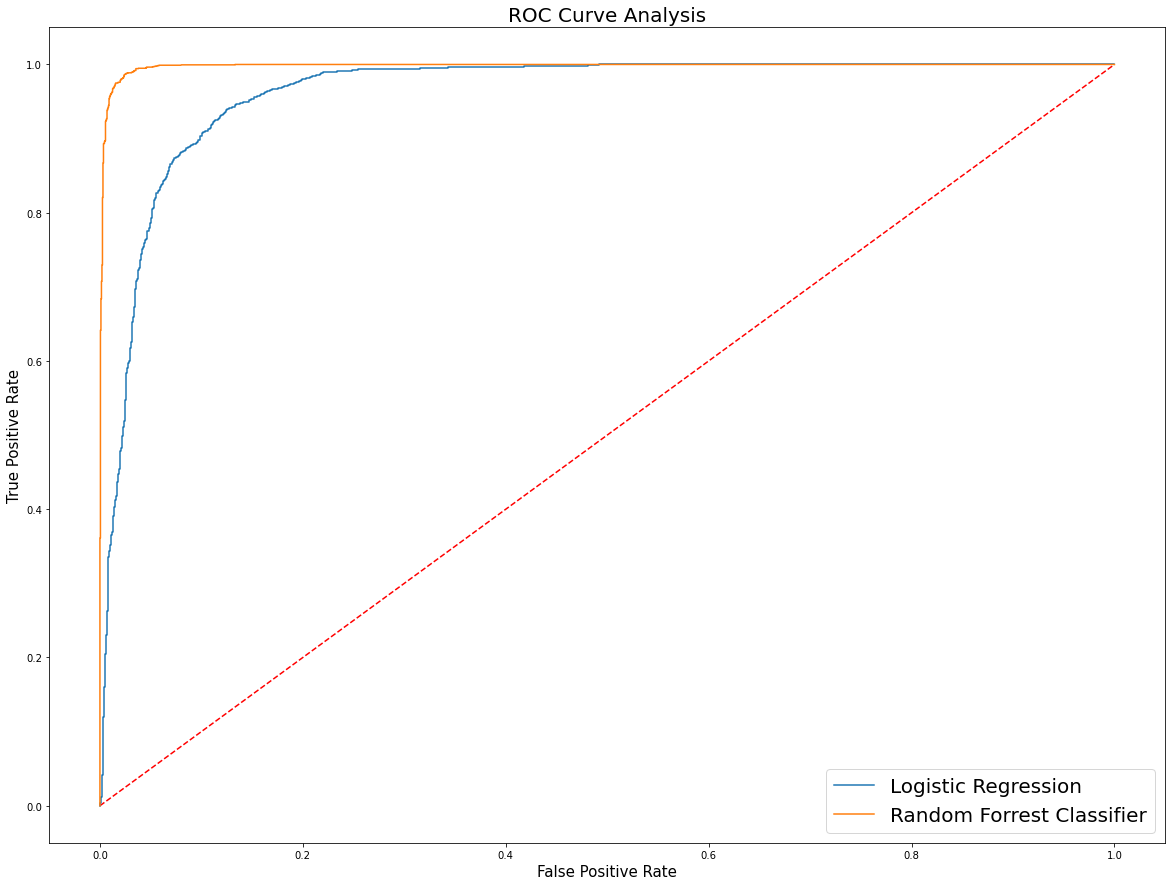

In [30]:
fig = plt.figure(figsize=(20,10))
y_pred_logtune = logreg_tuned.predict_proba(X_test)[:,1]
hp_fpr, hp_tpr, hp_thresholds =roc_curve(y_test, y_pred_logtune)
y_pred_rfcgrid = rfc2.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, rf_thresholds =roc_curve(y_test, y_pred_rfcgrid)
plt.plot([0,1],[0,1], 'r--')
plt.plot(hp_fpr,hp_tpr,label='Logistic Regression')
plt.plot(rf_fpr,rf_tpr,label='Random Forrest Classifier')
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('ROC Curve Analysis', fontsize=20)
plt.legend(prop={'size':20}, loc='lower right')
plt.show();

In [ ]:
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
rf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1)
rf_model = rf.fit(X_train, y_train)
sorted(zip(rf_model.feature_importances_, X_train.columns),reverse=True)[0:10]
'''